# Impact of hate groups on hate crimes in the USA

***Summary *** / [Data import and cleaning](https://github.com/gemmaaa/capstone_projects/blob/master/Hate_in_USA_1.Data_import.ipynb) / [Data analysis](https://github.com/gemmaaa/capstone_projects/blob/master/Hate_in_USA_2.Data_analysis.ipynb) / [Modeling](https://github.com/gemmaaa/capstone_projects/blob/master/Hate_in_USA_3.Modeling.ipynb)

## Abstract

The aim of this project is to quantify the impact of hate groups presence on crime in their area, and to analyze patterns associated with each hate group and hate bias type on a state and local level from 2004 through 2016 across the USA. 

Models used in this project include random forest regression, K Nearest Neighbors regression, and gradient boosting regression with multi output regressor. Across these models, about 80% of the variance in hate crimes in each bias category was able to be explained, though some models preformed better than others. Additionally, with these models, I was able to identify features that were indicative of the number of hate crimes in each bias category. 

## Introduction

Though the visibility of hate groups across the USA range from completely hidden to flagrant, through social media and online publications, among other modern resources, their presence and their members are becoming more widely known. The impact of hate speech and hate groups is widely damaging, as studied by many collaboratives such as the [Sussex Hate Crime Project](http://www.sussex.ac.uk/psychology/sussexhatecrimeproject/) and the [Southern Poverty Law Center](https://www.splcenter.org/). 

Using the increasingly available data, quantifying the impacts of the presence and kinds of hate groups can help communities gain awareness of the groups in their region, anticipate crimes of different types, and thus be better able to respond and address the hidden issues these groups are symptomatic of.


### Research questions

* Does the presence of hate groups in a city or a state increase the number of hate crimes in the vicinity?
* What patterns of growth or decline are apparent in each hate group type? 


## Data 

The data used in this project consists of annual [Hate Maps](https://www.splcenter.org/hate-map) provided by the SPLC and the [UCR](https://www.fbi.gov/services/cjis/ucr) [Annual Hate Crime Statistics](https://www.fbi.gov/services/cjis/ucr/hate-crime) from the FBI. The years of data used in this analysis are specifically from 2004 through 2016 due to differences in recording data prior to year 2004. 

The Hate Map data provides names of hate groups, their hate group type categorized as one of 7 possible groups, and city of their presence, state, and year. The 7 hate types are: 

The FBI has a slew of statistics available each year, but the data I have specifically used in this project is Table 11,crimes by bias motivation with year and state identifiers, and Table 13, incidents by bias motivation with year, state, and in some cases city identifiers.


***Note*** This is a summary of 3 other notebooks which you can take a look at for more details: Data import and cleaning,  Analysis, and Modeling.

### Import statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

# Statistical tests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# NLP
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
import string

import networkx as nx

from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser


# Modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

# Clustering
from sklearn.cluster import MeanShift, estimate_bandwidth



## Data Import

I imported, processed, and cleaned up data from the FBI into the following dataframes:

* **state_totals**, consisting of 542 records, which has the number of hate crimes by bias committed, total number of offenses, and offense types, by state and year,  and

* **by_city_only**, consisting of 21,178 records with the same information but by city, for all the cities that have submitted data to the FBI. 


I also made heavy use of the **hatemaps**  from the SPLC, and imported that into a dataframe, which has the names of all of the hate groups in the USA, the category of hate type that they fall under, the location of each of their (known) chapters (state, and city where possible), and the year in which the data was collected.

For specifics on this, please see the [Data import and cleaning](https://github.com/gemmaaa/capstone_projects/blob/master/Hate_in_USA_1.Data_import.ipynb) notebook.

Some of the features added to state_totals and by_city_only also were made during the [data analysis](https://github.com/gemmaaa/capstone_projects/blob/master/Hate_in_USA_2.Data_analysis.ipynb) notebook. 

In [2]:
hatemaps = pd.read_csv('/Users/gemma/Documents/data science/fc-hatemaps.csv')
crimes_by_state = pd.read_csv('/Users/gemma/Documents/data science/fc-crimes_by_state.csv')
bias_crimes_bt = pd.read_csv('/Users/gemma/Documents/data science/fc-partial_bias_byst.csv')

state_totals = pd.read_csv('/Users/gemma/Documents/data science/fc-hate-state_totals_v2.csv')
by_city_only = pd.read_csv('/Users/gemma/Documents/data science/fc-hate-by_city_v2.csv')

In [3]:
state_totals.head()

,Year,State,REA,Religion,Disability,Gender,Gender Identity,Sexual orientation,Total offenses,Aggravated assault,...,Radical Traditional Catholicism,White Nationalist,national socialist movement,brotherhood of klans knights of the ku klu klan,loyal white knights of the ku klu klan,national socialist movement - nsm,nation of islam,united northern and southern knights of the ku klu klan,Total crimes persons,Total crimes property
0,2006,AL,1.0,0.0,0.0,0.0,0.0,0.0,1,0,...,0.0,3.0,22,22,22,22,22,22,1.0,0
1,2006,AK,4.0,0.0,0.0,0.0,0.0,2.0,11,3,...,0.0,0.0,1,1,1,1,1,1,10.0,1
2,2006,AZ,90.0,30.0,1.0,0.0,0.0,28.0,215,23,...,0.0,0.0,10,10,10,10,10,10,158.0,57
3,2006,AR,97.0,3.0,2.0,0.0,0.0,11.0,133,16,...,0.0,1.0,19,19,19,19,19,19,81.0,52
4,2006,CA,844.0,204.0,3.0,0.0,0.0,246.0,1604,372,...,2.0,1.0,63,63,63,63,63,63,997.0,607


In [4]:
by_city_only.head()

,Year,State,Agency name,REA,Religion,Disability,Gender,Gender Identity,Sexual orientation,Total offenses,...,Radical Traditional Catholicism,White Nationalist,national socialist movement,brotherhood of klans knights of the ku klu klan,loyal white knights of the ku klu klan,national socialist movement - nsm,nation of islam,united northern and southern knights of the ku klu klan,Total crimes persons,Total crimes property
0,2006,AL,Atmore,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2006,AK,Anchorage,4.0,0.0,0.0,0.0,0.0,2.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0
2,2006,AZ,Apache Junction,1.0,0.0,0.0,0.0,0.0,0.0,215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.0,57.0
3,2006,AZ,Bullhead City,1.0,0.0,0.0,0.0,0.0,0.0,215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.0,57.0
4,2006,AZ,Chandler,7.0,0.0,0.0,0.0,0.0,0.0,215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.0,57.0


## Exploratory Data Analysis

For the full details, please also see the [Data analysis](https://github.com/gemmaaa/capstone_projects/blob/master/Hate_in_USA_2.Data_analysis.ipynb) notebook.

First, I continued merging the tables in order to gather some basic statistics, such as number of hate groups per city, number of hate types represented in each city / state, and number of hate groups in each type by city / state. 

### Total number of hate groups

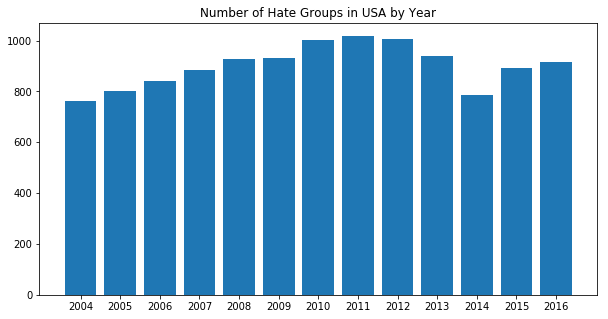

In [5]:
overall_year = hatemaps.groupby('Year')['Group Name'].count() 

overall_year = overall_year.reset_index()

plt.figure(figsize=(10,5))
plt.bar(x=overall_year.iloc[:,0], height=overall_year.iloc[:,1])
plt.xticks(overall_year.iloc[:,0])
plt.title('Number of Hate Groups in USA by Year')
plt.show()

It appears that for the most part, hate group numbers were growign from 2004 through 2011, after which they started to dip, until 2014, where they began increasing rather rapidly, again.

### Number of hate groups in each state

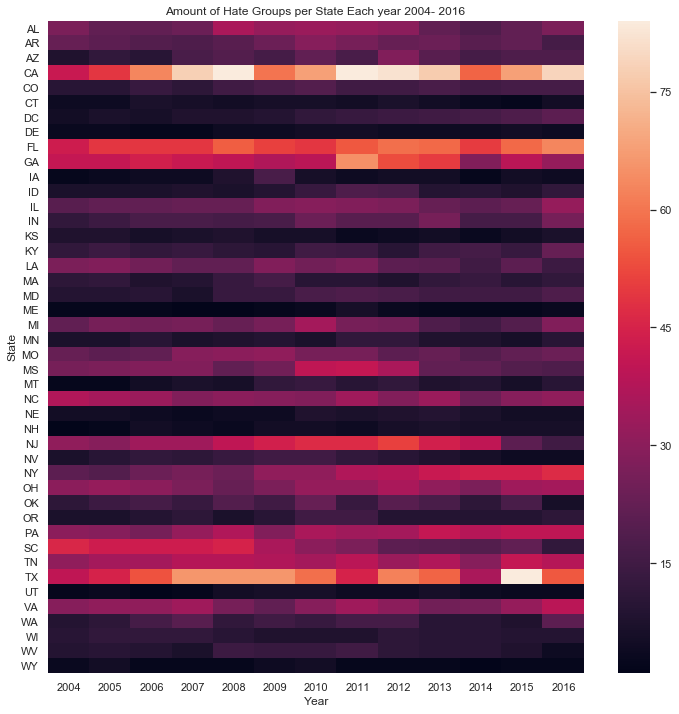

In [6]:
sns.set()                      

count_by_state = hatemaps.groupby(['State', 'Year'])['Group Name'].count().unstack().dropna()

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(count_by_state,
            linewidths=0, ax=ax)
plt.title('Amount of Hate Groups per State Each year 2004- 2016 ')
plt.show()


The heatmap above is a little bit hard to read but at a glance, shows the general amount of hate groups in each state is low, and shows a couple of outliers such as Texas, especially in 2015, GA, FL and CA in general. Let's take a look at the boxplot of each state to get another perspective.

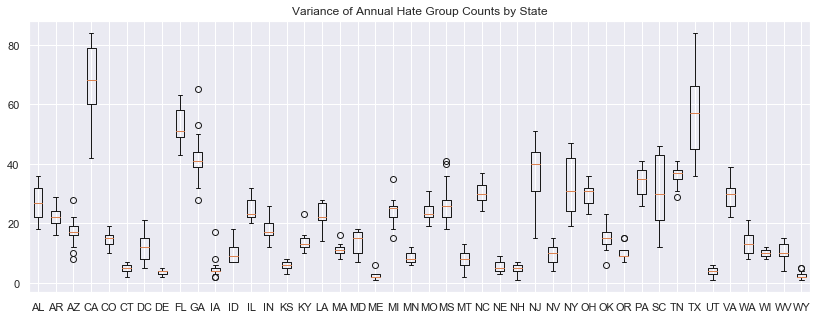

In [7]:
plt.figure(figsize=(14,5))
plt.boxplot(count_by_state, labels=count_by_state.index.values)
plt.title("Variance of Annual Hate Group Counts by State")
plt.show()

With this look, it is easier to see the outliers and how different they are from the other states - namely, CA, FL, GA, and TX. It is also interesting to see what each state's average and standard deviation is. CA seems to have a higher amount on average and a wide range, while TX, for example, has a wider ranger and a lower number on average.

### Number and size of of different hate (group) types

The hate groups are divided up into the following hate types: 

* 'Anti-Immigrant',  
* 'Anti-LGBT',
* 'Anti-Muslim',
* 'Black Nationalist',
* 'Christian Identity',
* 'General/Other',
* 'Holocaust Denial',
* 'Ku Klux Klan',
* 'Neo-Confederate',
* 'Neo-Nazi',
* 'Racist / Hate Music',
* 'Racist Skinhead',
* 'Radical Traditional Catholicism',
* 'White Nationalist'

There are different ways to quantify the size of each hate type. Let's look at a couple different ones to try and get a clearer picture.

First, let's look at the size of each hate type, as the number of hate group chapters each hate type holds. I'll plot the annual distribution. 

#### Number of group chapters in each hate type

Some of the data is missing, for example, in years when data about certain hate types wasn't collected yet. However, in order to show the general variances, I have filled in the missing values with the average of each type's annual size.

In [8]:
count_ht_overall = hatemaps.groupby(['Year','Hate Type'])['Group Name'].count().unstack().T

# filling with the mean

m = count_ht_overall.mean(axis=1)
for i, col in enumerate(count_ht_overall):
    # using i allows for duplicate columns
    count_ht_overall.iloc[:, i] = count_ht_overall.iloc[:, i].fillna(m)

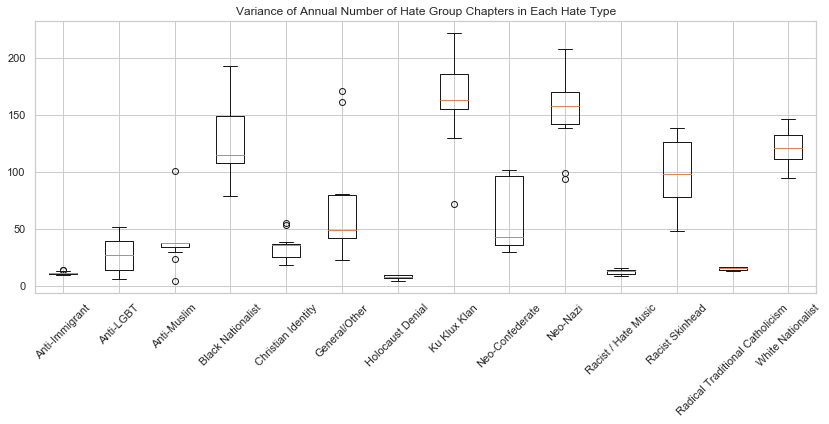

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(14,5))
plt.boxplot(count_ht_overall, labels=count_ht_overall.index.values)
plt.title("Variance of Annual Number of Hate Group Chapters in Each Hate Type")
plt.xticks(rotation=45)
plt.show()

It looks like Black Nationalist, the KKK, and Neo Nazi are generally, at any given time, the types with the largest number of chapters, followed by Racist/Skinhead and White Nationalist.

General/other had a couple surprisingly high outliers, but other than that the general number of chapters in each remaining hate type was at or below 100.

<hr />


Let's back up for a minute and look at another metric of hate type size - the number of unique hate groups in each hate type, chronologically. 

#### Number of unique hate groups in each hate type

Because of the large amounts of groups, I've split this into two graphs so it will be easier to und baesd on the median of the means of each hate type size over the years.

In [10]:
# size of hate types by number of groups in each

group_year = hatemaps.groupby(['Year','Hate Type'])['Group Name'].nunique().unstack()

larger_half = []
smaller_half = []

for col in group_year.columns.values:
    # if the mean size of this hate type is greater than the median mean size of all the types..
    if np.mean(group_year[col]) >= np.median(np.mean(group_year)):
        larger_half.append(col)
    else:
        smaller_half.append(col)
        
# making smaller dataframes
larger_ht = hatemaps.loc[hatemaps['Hate Type'].isin(larger_half)]
smaller_ht = hatemaps.loc[hatemaps['Hate Type'].isin(smaller_half)]

In [11]:
# grouping them to get the count of Groups per Hate Type in each dataframe
larger_grouped = larger_ht.groupby(['Year','Hate Type'])['Group Name'].nunique().unstack()
smaller_grouped = smaller_ht.groupby(['Year','Hate Type'])['Group Name'].nunique().unstack()

# pushing the index over so "year" becomes a column
larger_grouped = larger_grouped.reset_index()
smaller_grouped = smaller_grouped.reset_index()

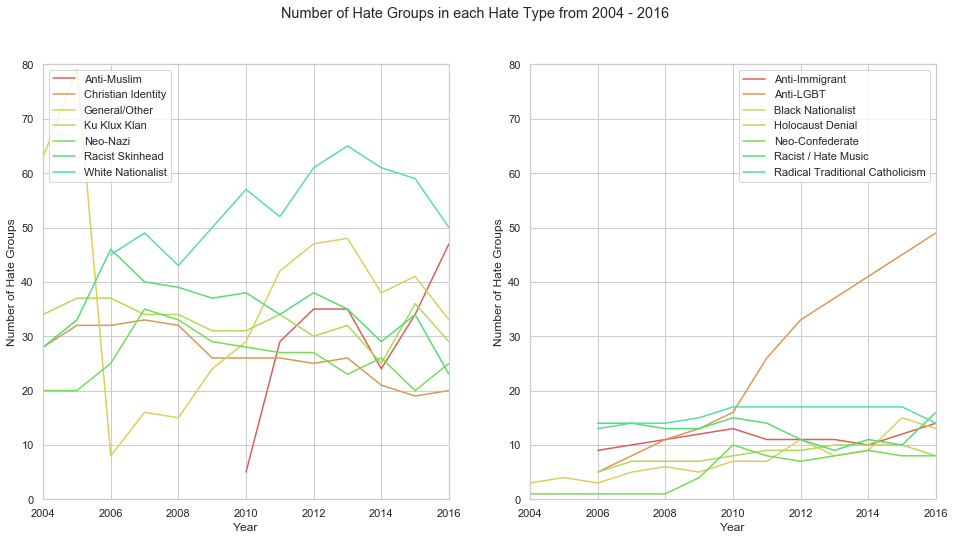

In [12]:
# plotting on 2 separate line plots to see the data more clearly

sns.set(style="whitegrid")
sns.set_palette("hls", n_colors=14)

plt.figure(figsize=(16,8))
plt.suptitle('Number of Hate Groups in each Hate Type from 2004 - 2016')

plt.subplot(1,2,1)
ax = plt.gca()
for col in larger_half:
    larger_grouped.plot(kind='line',x='Year',y=col,ax=ax)
plt.ylim(0,80)
plt.xlim(2004,2016)
ax.set(ylabel='Number of Hate Groups', xlabel="Year")

plt.subplot(1,2,2)
ax = plt.gca()
for col in smaller_half:
    smaller_grouped.plot(kind='line',x='Year',y=col,ax=ax)
plt.ylim(0,80)
plt.xlim(2004,2016)
ax.set(ylabel='Number of Hate Groups', xlabel="Year")

plt.show()

It appears that the number of White Nationalist groups was higher than the majority of the the other groups, and generally increased from 2004 until 2013, at which point the number of groups started to drop. 

There is also an interesting outlier in General / Other, with a large number in year 2005, and then a large drop. This could be due to reclassifying the groups, perhaps, so we'll take that with a grain of salt.

Also of note is that some groups either only existed, or were counted, from year 2006. Finally, while most Hate Types do not have a steady increase, there are 2 exceptions to this - Anti-Muslim (had one drop in 2014, but other than that, steady incline) and Anti-LGBT.

####  Number of states with each hate type's presence

Let's take a quick general look at the number of states where each hate type has chapters, organized by year, so we can see the spread of each hate type over time.

First, we can look at the annual variance, and then we can look at each hate type chronologically.

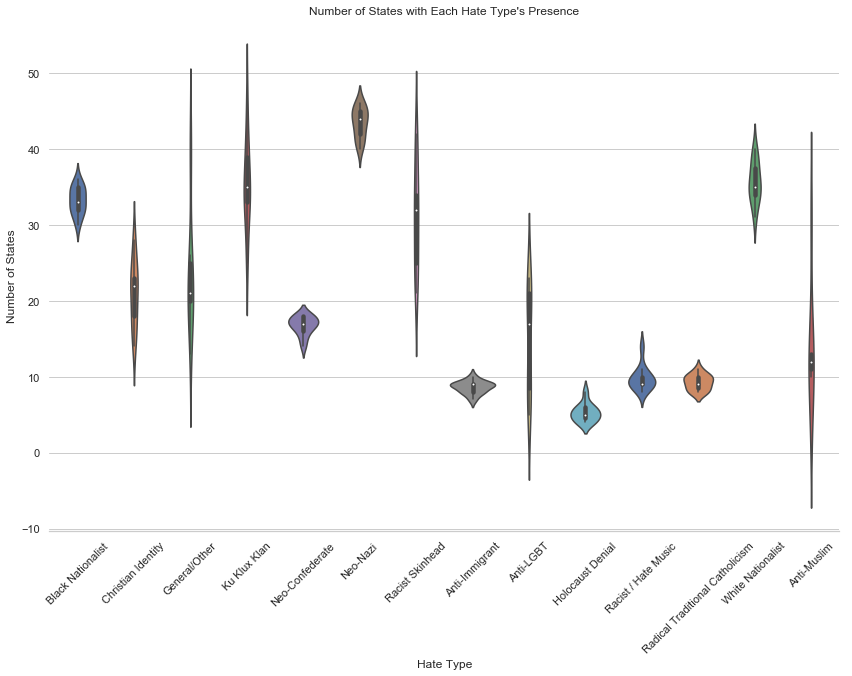

In [13]:
state_type = hatemaps.groupby(['Year',
                  'Hate Type'])['State'].nunique().dropna()
state_type = state_type.reset_index()

sns.set(style="whitegrid")

g = sns.catplot(x="Hate Type", y="State", data=state_type, aspect=1.5,
                   height=8, kind="violin", palette="deep",ci=95, dodge=True)
g.despine(left=True)
g.set_ylabels("Number of States")
g.set_xticklabels(rotation=45)
plt.title("Number of States with Each Hate Type's Presence")
plt.show()

The graph above just shows the variance / distribution of the number of states of each hate group over the time period, without clearly showing the growth or decline linearly, which we'll look at below. However, it does show the types with the largest consistent number of states and the ones with the greatest and least variance, or the hate types that have had the greatest changes.

It looks like the following groups had the greatest growth/decline: General/Other, Racist Skinhead, Anti LGBT, and Anti-Muslim.

The groups that appear to have maintained the largest number of states consistently are Neo Nazi, and White Nationalist, followed by Black Nationalist.

At a glance they look to be quite different. Let's see if the difference is statistically significant. We'll use the Tukey range test because the variances aren't normally distributed and there are multiple pairwise comparisons.



In [14]:
compare_htypes = state_type.pivot_table(columns="Hate Type", index="Year",values="State")
types = compare_htypes.columns.values.tolist()

goodluck = []

for col in types:
    ok = compare_htypes[col].fillna(0).tolist()
    for val in ok:
        goodluck.append(val)

heights=np.asarray(goodluck)

materials = np.array(types)
materials = np.repeat(materials, 13)

tukey = pairwise_tukeyhsd(endog=heights,      # Data
                          groups=materials,   # Groups
                          alpha=0.05)         # Significance level

#tukey.summary() 

# Since there are so many comparisons here, I'm just going to show the ones where the null 
# hypothesis should be rejected (reject = True)
df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

In [15]:
df[df['reject'] == True].head()

,group1,group2,meandiff,lower,upper,reject
2,Anti-Immigrant,Black Nationalist,25.9231,17.4989,34.3473,True
3,Anti-Immigrant,Christian Identity,13.6923,5.2681,22.1165,True
4,Anti-Immigrant,General/Other,16.2308,7.8066,24.6550,True
6,Anti-Immigrant,Ku Klux Klan,28.0000,19.5758,36.4242,True
7,Anti-Immigrant,Neo-Confederate,9.4615,1.0373,17.8858,True


It appears that the differences visible in the violin plot are statistically significant.

Next, let's look at the size changes of each group over time.

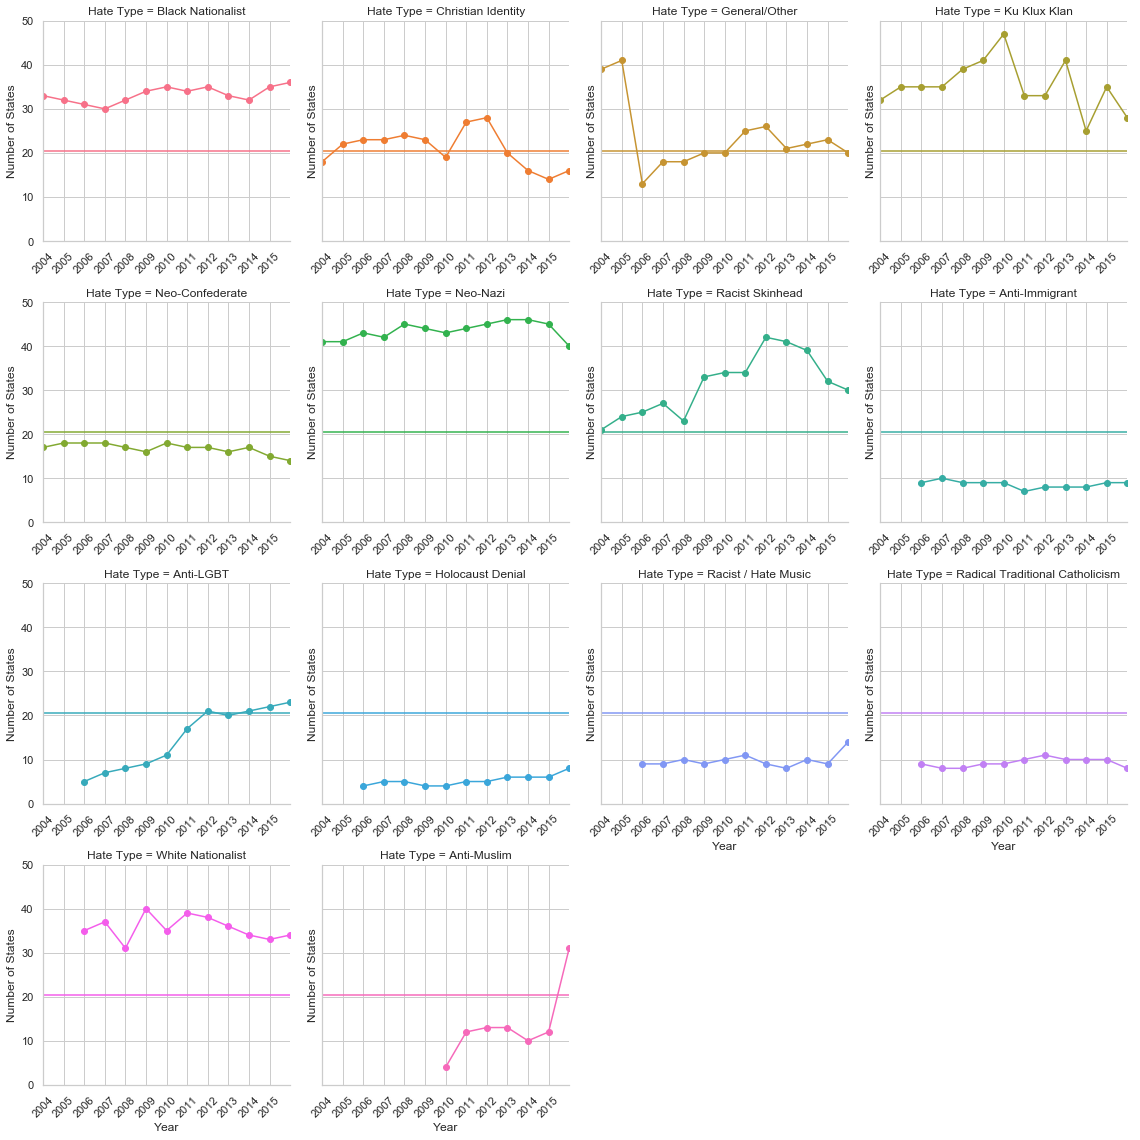

In [16]:
sns.set(style="whitegrid")

g = sns.FacetGrid(state_type, col='Hate Type', col_wrap=4, height=4,
                 ylim=(0,50), xlim=(min(state_type['Year']),max(state_type['Year'])),  palette="husl", hue="Hate Type")

g.map(plt.axhline, y=np.median(state_type['State']))
g = g.map(plt.plot,'Year','State',marker="o") 


g.set(xticks=np.arange(min(state_type['Year']),max(state_type['Year'])), ylabel="Number of States")

for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45)

g.fig.tight_layout(w_pad=1)

plt.show()




Looking at the graph certain inclines and declines are apparent. In places where the graphed line doesn't start at 2004, that means that data on that hate type wasn't collected until the year that the line starts at.


#### Hate groups with chapters in the largest number of states

In [17]:
hatemaps.groupby(['Year',
                  'Group Name'])['State'].nunique().sort_values(ascending=False).head(10)

Year  Group Name                                     
2013  national socialist movement                        43
2012  national socialist movement                        41
2014  national socialist movement                        40
2011  national socialist movement                        39
2015  national socialist movement                        39
2010  brotherhood of klans knights of the ku klu klan    38
2013  loyal white knights of the ku klu klan             38
2006  national socialist movement                        35
2009  national socialist movement - nsm                  35
2012  nation of islam                                    34
Name: State, dtype: int64

It looks like the NSM and different chapters of the KKK have chapters in the largest number of states consistently for most of the years we are analyzing.


Let's also look at the count of unique cities to get an idea of the density of the hate group sizes in each state.

In [18]:
hatemaps.groupby(['Year','Group Name'])['City'].count().sort_values(ascending=False).head(10)


Year  Group Name                 
2012  nation of islam                105
2007  league of the south            102
2006  league of the south            100
2005  league of the south             97
2004  league of the south             96
2008  league of the south             90
2011  nation of islam                 84
2016  nation of islam                 81
2006  national socialist movement     81
2015  nation of islam                 80
Name: City, dtype: int64

The nation of Islam has had the largest geographical presence by chapter count, followed by the nation of islam, and in this count, the national socialist movement is only third instead of first. 

From this data, it appears that some of the groups that exist in more cities are more concentrated in certain states.

#### Types of Crimes in the areas of the 5 largest hate groups

Let's look at the impact of these hate groups on crime. First, I gathered the names of the 5 largest hate groups (largest in this case will be with chapters in the greatest number of states), like in the 1st table above. Then I added it in the dataframe as a count. You can see the full process of this in the full notebook.

In [19]:
topfive = hatemaps.groupby(['Year',
                  'Group Name'])['State'].nunique().sort_values(ascending=False).reset_index()['Group Name'].head(10).unique().tolist()


In [20]:
# making list of crime categories

crimes_c_persons = ['Aggravated assault','Intimidation',
                    'Murder and non negligent manslaughter','Simple assault', 
                    'Rape (legacy)', 'Rape (revised)', 'Other Crimes c persons']
crimes_c_property = ['Arson', 'Burglary', 'Destruction damage vandalism',
                     'Larceny theft', 'Motor vehicle theft', 'Robbery',
                     'Other Crimes c property']
crimes_c_society = ['Crimes c society']


In [21]:
old_crimes = ['Total offenses', 'Aggravated assault', 'Intimidation',
       'Murder and non negligent manslaughter', 'Simple assault',
       'Rape (legacy)', 'Rape (revised)', 'Other Crimes c persons',
       'Arson', 'Burglary', 'Destruction damage vandalism',
       'Larceny theft', 'Motor vehicle theft', 'Robbery',
       'Other Crimes c property', 'Crimes c society']

crimes = ['Total crimes persons', 'Total crimes property','Crimes c society']
biases = ['REA','Religion','Disability','Gender', 'Gender Identity','Sexual orientation']

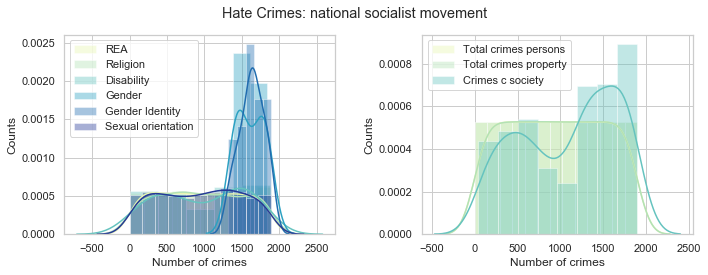

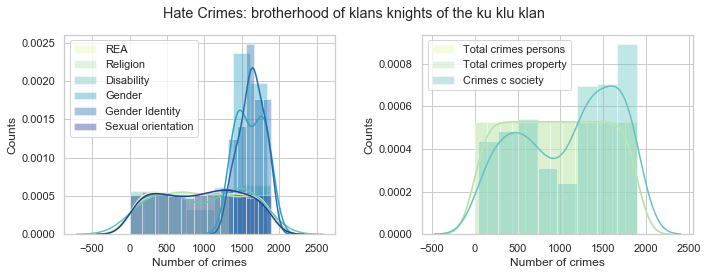

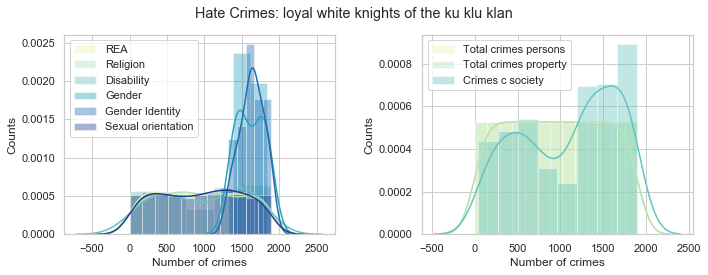

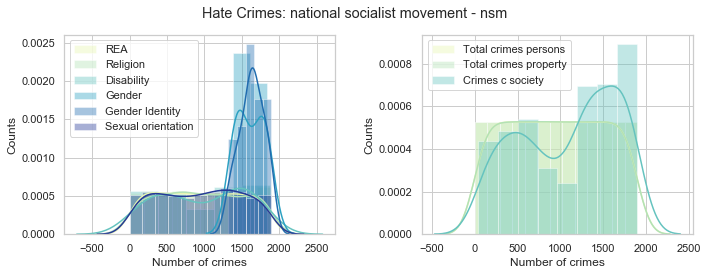

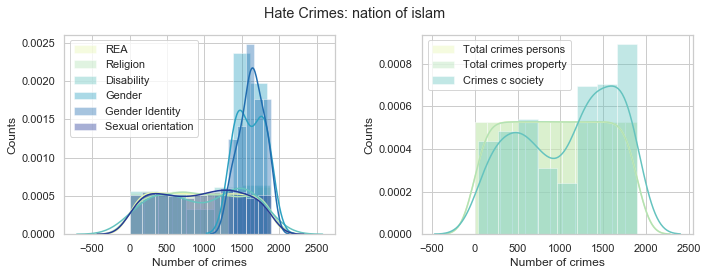

In [22]:
amess2 = by_city_only

for htype in topfive:
    
    sns.set(style="whitegrid", palette="YlGnBu")

    plt.figure(figsize=(10,4))
    plt.suptitle('Hate Crimes: '+htype)
    plt.subplot(1,2,1)
    ax = plt.gca()
    for col in biases:
        ax = sns.distplot(amess2[amess2[htype] > 0][col].nonzero(), label=col, hist=True) 
        ax.set(ylabel="Counts", xlabel="Number of crimes")
    plt.legend()
    
    plt.subplot(1,2,2)
    ax = plt.gca()
    for col in crimes:
        ax = sns.distplot(amess2[amess2[htype] > 0][col].nonzero(), label=col, hist=True)
        ax.set(ylabel="Counts", xlabel="Number of crimes")
        ax.legend()
    
    plt.tight_layout(w_pad=2, rect=[0, 0.03, 1, 0.95])

    plt.show()

It looks like the distributions are exactly the same. Maybe looking at just specific hate groups is not enough - these 5 hate groups are a relatively small sample size when compared to the rest of the hate types. 

Let's look at a slightly wider view.

#### Types of Crimes in the areas of hate types

This will look at the types of crimes in locations with one or more hate group from each hate type.

In [23]:
#  going to rename some columns for the sake of the labels

crimes_c_persons = ['A assault', 'Intimidation', 'Murder','S assault', 
                    'Rape L', 'Rape R', 'Other Pl']
crimes_c_property = ['Arson', 'Burglary', 'Destruction',
                     'Larceny', 'MV theft', 'Robbery',
                     'Other Pr']
crimes_c_society = ['Crimes c society']


amess2 = by_city_only.rename(index=str, columns={'Aggravated assault': 'A assault',
                    'Murder and non negligent manslaughter': 'Murder',
                    'Simple assault': 'S assault', 
                    'Rape (legacy)': 'Rape L', 'Rape (revised)': 'Rape R', 
                    'Other Crimes c persons' : 'Other Pl',
                     'Destruction damage vandalism': 'Destruction',
                     'Larceny theft':'Larceny', 'Motor vehicle theft':'MV theft',
                     'Other Crimes c property': 'Other Pr'})

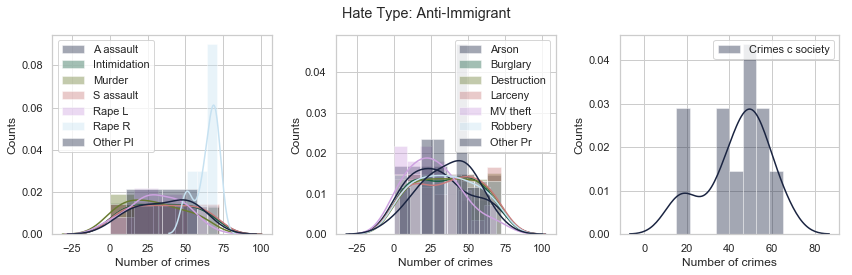

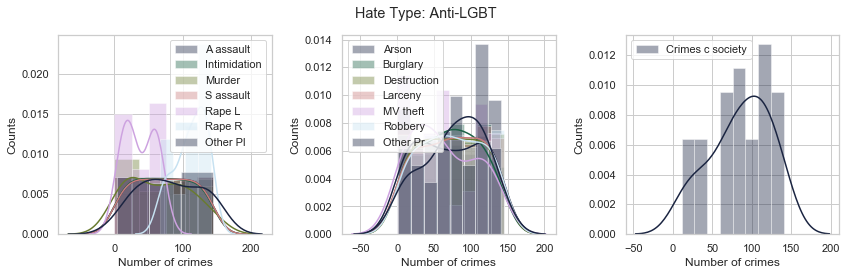

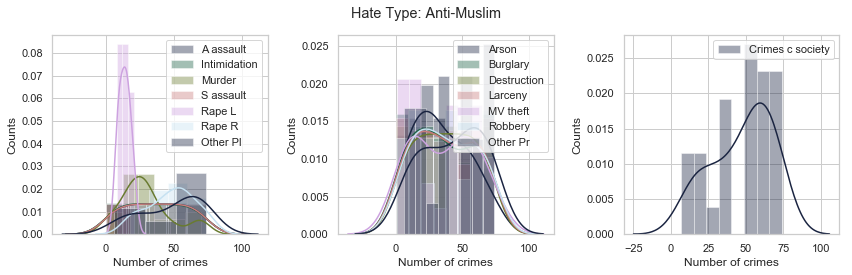

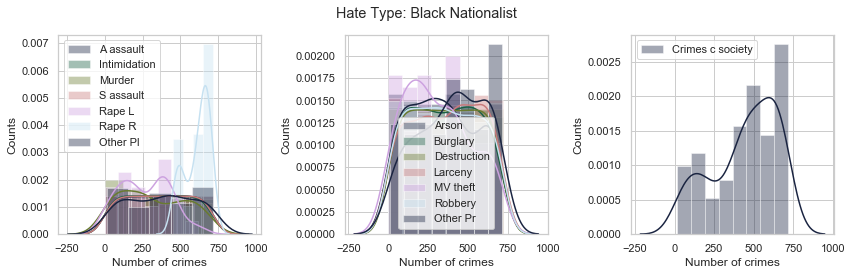

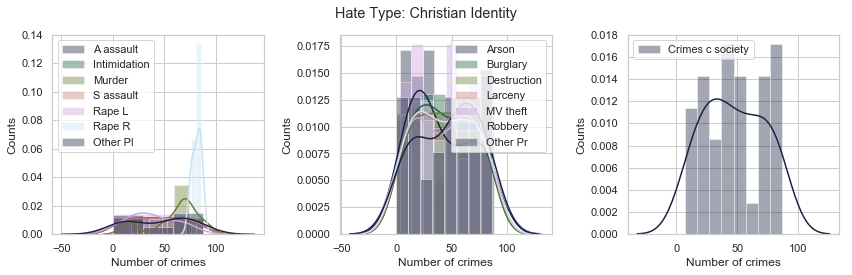

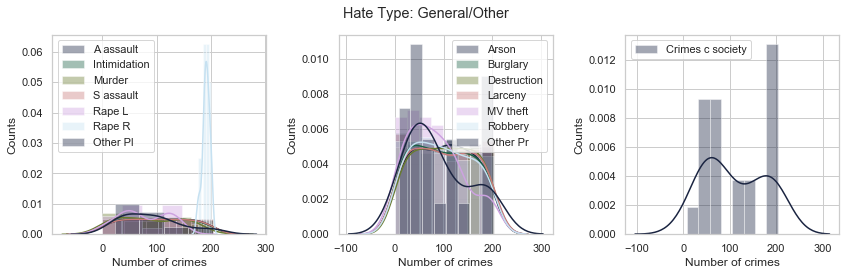

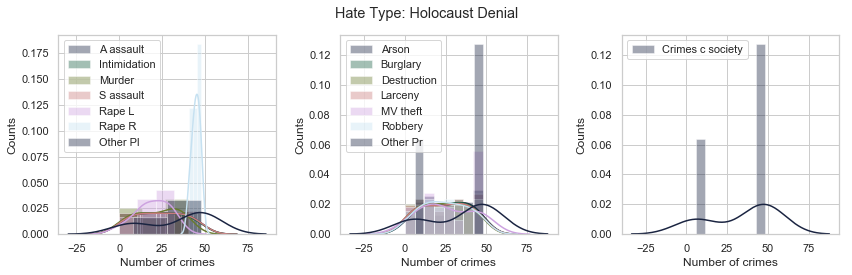

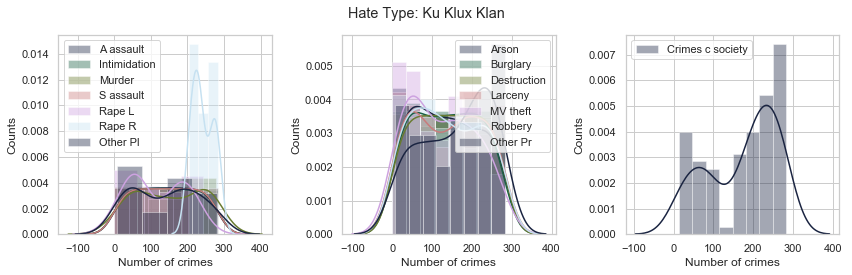

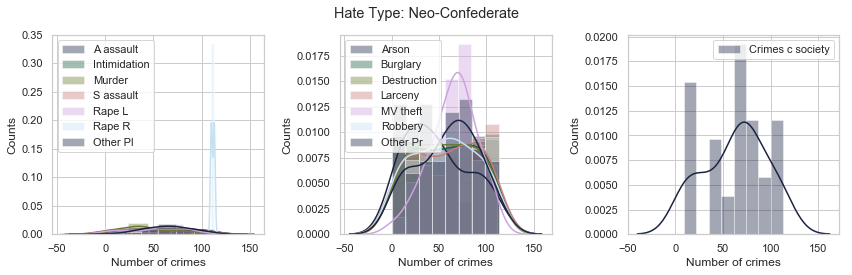

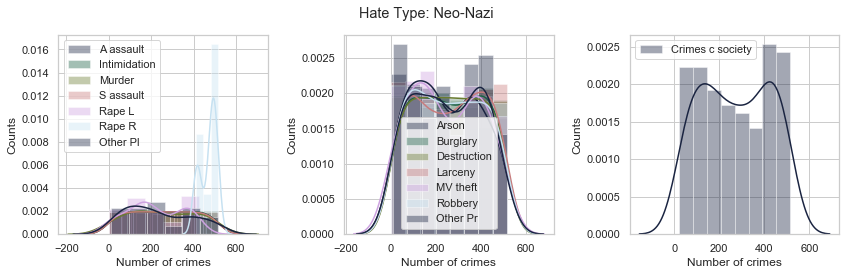

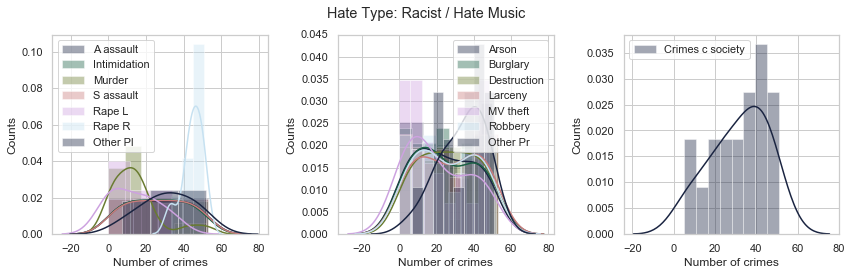

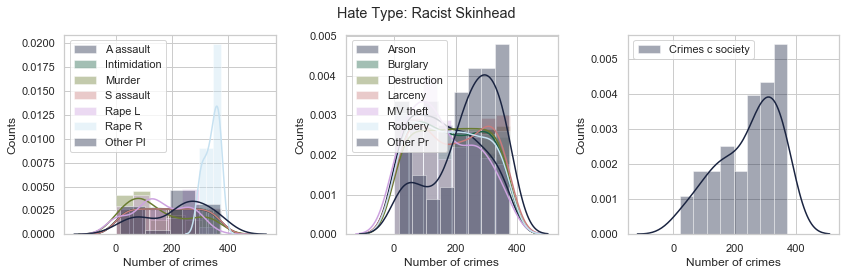

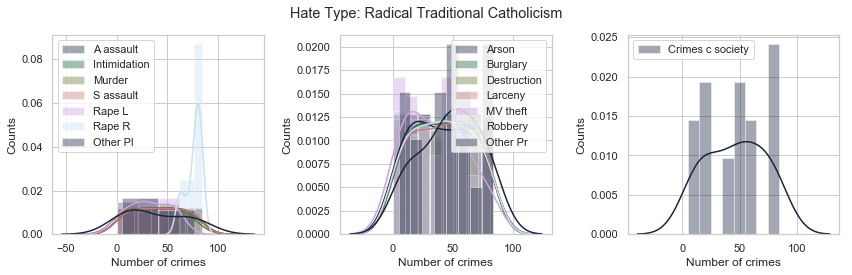

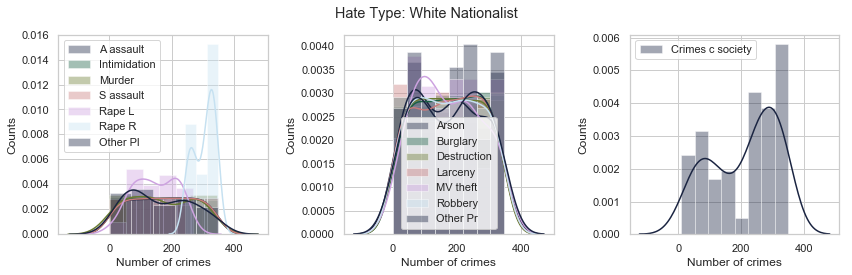

In [24]:
hatetypes = ['Anti-Immigrant','Anti-LGBT', 'Anti-Muslim', 
             'Black Nationalist', 'Christian Identity',
       'General/Other', 'Holocaust Denial', 'Ku Klux Klan', 'Neo-Confederate',
       'Neo-Nazi', 'Racist / Hate Music', 'Racist Skinhead',
       'Radical Traditional Catholicism', 'White Nationalist']

for htype in hatetypes:
    
    sns.set(style="whitegrid", palette="cubehelix")

    plt.figure(figsize=(12,4))
    plt.suptitle('Hate Type: '+htype)
    plt.subplot(1,3,1)
    ax = plt.gca()
    for col in crimes_c_persons:
        ax = sns.distplot(amess2[amess2[htype] > 0][col].fillna(0).nonzero(), 
                          label=col, hist=True) 
        ax.set(ylabel="Counts", xlabel="Number of crimes")
    plt.legend()
    
    plt.subplot(1,3,2)
    ax = plt.gca()
    for col in crimes_c_property:
        ax = sns.distplot(amess2[amess2[htype] > 0][col].fillna(0).nonzero(),
                          label=col, hist=True, bins=8)
        ax.set(ylabel="Counts", xlabel="Number of crimes")
        ax.legend()
        
    plt.subplot(1,3,3)
    ax = plt.gca()
    for col in crimes_c_society:
        ax = sns.distplot(amess2[amess2[htype] > 0][col].fillna(0).nonzero(),
                          label=col, hist=True, bins=8)
        ax.set(ylabel="Counts", xlabel="Number of crimes")
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

It appears that the distributions of different crimes does vary depending on which hate type is present. For example, Neo Nazis seem to have a higher number of Crimes against society than many other groups.


Let's compare with the distribution of hate crimes in each city by bias category.

#### Hate Crimes in Each Category per City


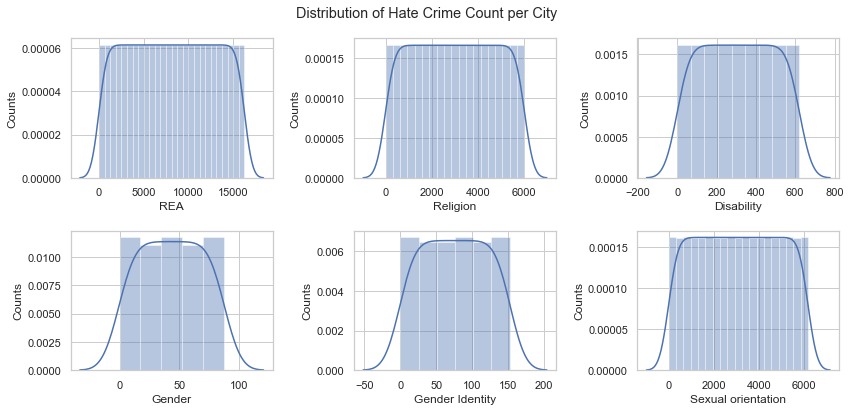

In [25]:
cols = ['REA', 'Religion', 'Disability', 'Gender',
       'Gender Identity', 'Sexual orientation']

sns.set(style="whitegrid")

f, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=False)
sns.despine(left=True)


for i in range(2*3):
    plt.subplot(2,3,i+1)
    ax = sns.distplot(by_city_only[by_city_only[cols[i]] > 0][cols[i]].dropna().nonzero(),
                 hist=True, label=cols[i])
    ax.set(ylabel="Counts", xlabel=cols[i])
    plt.tight_layout(w_pad=1, rect=[0, 0.03, 1, 0.95])
    
plt.suptitle('Distribution of Hate Crime Count per City')
plt.show()

Let's look at the number of hate crimes per city over time.

#### Chronological Number of hate crimes per city by type


In [26]:
# make a column to label the bias category in the row, as well as the count

bias_crimes_bt['Bias Category'] = np.nan
bias_crimes_bt['Count'] = np.nan

In [27]:
# adding in the values row by row

for i in range(len(bias_crimes_bt)):
    for x in cols:
        if bias_crimes_bt.loc[i, x] > 0:
            bias_crimes_bt.loc[i, 'Bias Category' ] = x
            bias_crimes_bt.loc[i, 'Count'] = bias_crimes_bt.loc[i, x]

In [28]:
# dropping the totals which will skew the results
bias_crimes_bt = bias_crimes_bt[bias_crimes_bt['Agency name'] != 'Total']

# getting the average across all the cities
grouped_bcbt = bias_crimes_bt.groupby(['Year','Bias Category'])['Count'].mean().reset_index()

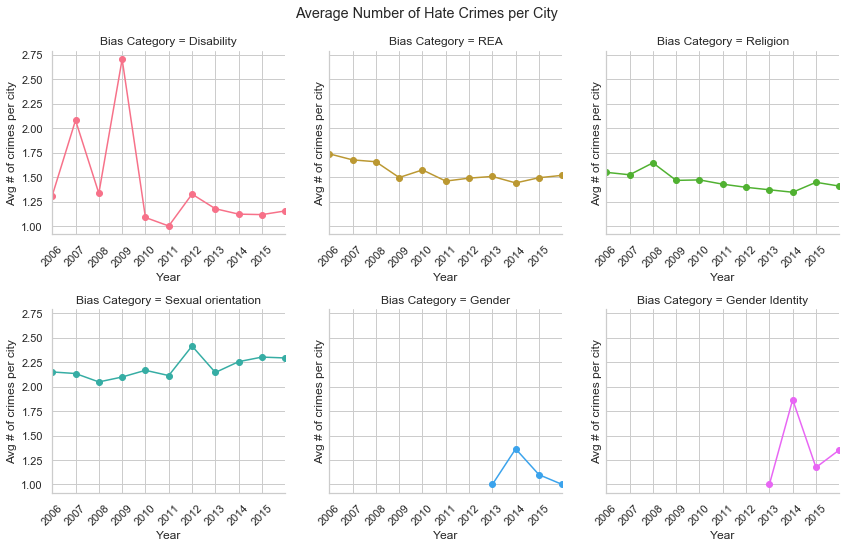

In [29]:
sns.set(style="whitegrid")

g = sns.FacetGrid(grouped_bcbt.dropna(), col='Bias Category', col_wrap=3, height=4,
                xlim=(min(grouped_bcbt['Year']),max(grouped_bcbt['Year'])), 
                palette='husl', hue='Bias Category')

g = g.map(plt.plot,'Year', 'Count', marker="o") 

g.set(xticks=np.arange(min(grouped_bcbt['Year']), max(grouped_bcbt['Year'])), 
      ylabel="Avg # of crimes per city", xlabel="Year")

for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45)

g.fig.tight_layout(w_pad=2, rect=[0, 0.03, 1, 0.95])

plt.suptitle('Average Number of Hate Crimes per City')
plt.show()

In [30]:
# getting the variance across all the cities

sum_of_counts = bias_crimes_bt.groupby(['Year','State',
                'Agency name','Bias Category'])['Count'].sum().reset_index()

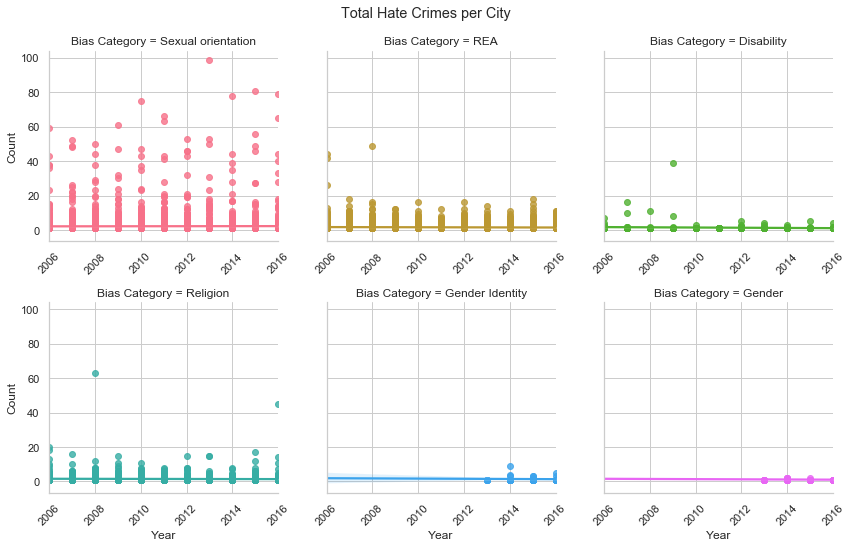

In [31]:
sns.set(style="whitegrid")

g = sns.lmplot(x="Year", y="Count", hue="Bias Category", col="Bias Category",
               col_wrap=3, height=4, data=sum_of_counts, palette='husl')


g = (g.set(xlim=(min(sum_of_counts['Year']), max(sum_of_counts['Year']))))

for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45)

g.fig.tight_layout(w_pad=2, rect=[0, 0.03, 1, 0.95])

plt.suptitle('Total Hate Crimes per City')

plt.show()

Let's use the Tukey test to see if the differences are statistically significant.

In [32]:
# first let's drop any that don't have a bias category

bias_crimes_bt.dropna(axis=0, subset=['Bias Category'], inplace=True)


In [33]:
mc = MultiComparison(bias_crimes_bt['Count'].fillna(0), 
                     bias_crimes_bt['Bias Category'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
     group1           group2       meandiff  lower  upper  reject
-----------------------------------------------------------------
   Disability         Gender       -0.2513  -1.7284 1.2258 False 
   Disability    Gender Identity    0.017   -1.2883 1.3224 False 
   Disability          REA          0.1962  -0.3008 0.6932 False 
   Disability        Religion       0.1074  -0.4035 0.6184 False 
   Disability   Sexual orientation  0.8267   0.3239 1.3295  True 
     Gender      Gender Identity    0.2684   -1.578 2.1147 False 
     Gender            REA          0.4475  -0.9496 1.8447 False 
     Gender          Religion       0.3587  -1.0435 1.7609 False 
     Gender     Sexual orientation  1.078   -0.3212 2.4773 False 
Gender Identity        REA          0.1792   -1.035 1.3933 False 
Gender Identity      Religion       0.0904  -1.1296 1.3103 False 
Gender Identity Sexual orientation  0.8097  -0.4069 2.0262 False 
      REA 

Interestingly, it looks like the null hypothesis is only rejected for bias category Sexual orientation in comparison with Disability, REA, and Religion. The null hypothesis is that the differences in the variances are random, so rejecting the null hypothesis means that the differences are significant.

### Number of hate crimes in cities with hate groups, vs number of hate crimes in cities without hate groups

In [34]:
no_hate_groups = by_city_only.where(by_city_only['Hate Type Count'] == 0)

# drop where there is no year state and city - i must have made a mistake earlier
no_hate_groups.dropna(subset=['Year','State','City'], inplace=True)

one_plus_hg = by_city_only.where(by_city_only['Hate Type Count'] > 0)

# my previous mistake again... oops
one_plus_hg.dropna(inplace=True)

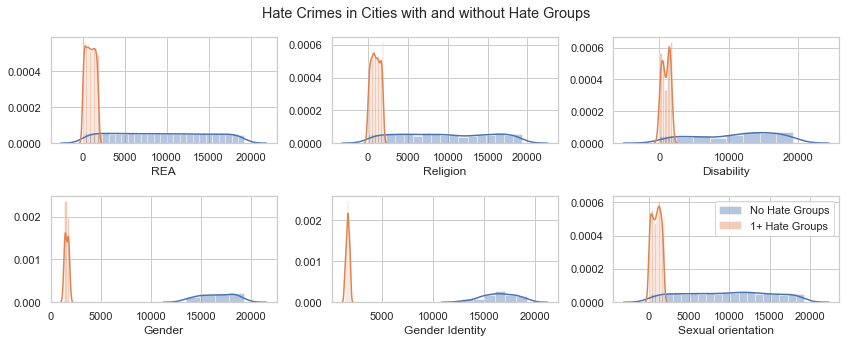

In [35]:
g = plt.figure(figsize=(12,5))
 
for i, col in enumerate(['REA', 'Religion', 'Disability',
       'Gender', 'Gender Identity', 'Sexual orientation']):
    
    plt.subplot(2,3,i+1)
    sns.distplot(no_hate_groups[col].nonzero(), label="No Hate Groups")
    sns.distplot(one_plus_hg[col].nonzero(), label="1+ Hate Groups")
    plt.xlabel(col)
    
plt.legend()
plt.suptitle('Hate Crimes in Cities with and without Hate Groups')
plt.tight_layout(w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()
    

In [36]:
no = by_city_only.groupby('Hate Type Count')['REA', 'Religion', 'Disability',
       'Gender', 'Gender Identity', 'Sexual orientation']

data_agg = no.agg(['mean'])

In [37]:
data_agg = data_agg.transpose()
data_agg

,Hate Type Count,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
REA,mean,1.630569,3.542265,7.449045,12.864706,16.261905,20.851064,25.047619,38.5,50.666667,74.0
Religion,mean,0.483014,0.799841,1.754777,3.217647,5.095238,20.361702,24.571429,80.0,109.000000,183.0
Disability,mean,0.035164,0.067783,0.098726,0.123529,0.119048,0.106383,0.095238,1.0,0.333333,1.0
Gender,mean,0.004616,0.002392,0.012739,0.041176,0.011905,0.000000,0.047619,0.0,0.000000,5.0
Gender Identity,mean,0.010269,0.023126,0.047771,0.135294,0.297619,0.148936,1.857143,0.5,4.000000,19.0
Sexual orientation,mean,0.399824,1.097289,3.242038,5.452941,8.547619,14.957447,18.333333,55.5,62.000000,79.0


The above table shows the number of different hate types that have at least 1 hate group in the city as columns, with the average number of hate crimes in each bias category for those same cities.

It appears that overarchingly, as the number of hate types present increases, the number of crimes by each bias increases overall. This isn't taking into consideration whether or not the hate type represented in that city is the same as the bias category targeted in each hate crime, and it also is looking at the overall numbers, meaning that it is considering hate groups in any year and hate crimes in any year.

## Modeling

For the full details, please also see the [Modeling](https://github.com/gemmaaa/capstone_projects/blob/master/Hate_in_USA_3.Modeling.ipynb) notebook.

### Feature engineering

First, some ideas of features that I had. Later, I'll use some unsupervised methods.

* Number of unique cities per state with at least 1 reported hate crime
* Max count of hate groups in any 1 city in each state
* Number of unique cities per state with at least 1 hate group
* Binary indicators of 5 largest hate groups presence in each city / state (added in the data analysis section)

In [38]:
state_totals = pd.read_csv('/Users/gemma/Documents/data science/fc-hate-state_totals_v2.csv')
by_city_only = pd.read_csv('/Users/gemma/Documents/data science/fc-hate-by_city_v2.csv')

In [39]:
# number of unique cities per state with at least 1 reported hate crime

state_totals = pd.merge(state_totals, 
                        by_city_only.groupby(['Year','State'])['Agency name'].nunique().reset_index().rename(index=str,
                            columns={'Agency name': 'Number of cities with 1+ hate crime'}), 
                        on=['Year','State'])

In [40]:
# max count of hate groups in 1 city in each state

state_totals = pd.merge(state_totals, hatemaps.groupby(['Year','State',
                  'City'])['Group Name'].count().groupby(['Year',
                 'State']).max().reset_index().rename(index=str,columns={'Group Name': 
                    'Largest num of hate groups in any 1 city'}),
                        on=['Year','State'])


In [41]:
# count of unique cities with 1 or more hate groups in each state per year

state_totals = pd.merge(state_totals, 
                        hatemaps.groupby(['Year',
                            'State'])['City'].nunique().reset_index().rename(index=str,
                            columns={'City': 'Number of cities with 1+ hate groups'}), 
                        on=['Year','State'])

In [42]:
# for the cumulatively largest 5 hate groups (by count) in each category, 
# binary indicators of whether or not they exist in each state

# first get the names of the hate groups
largest_five = []

for htype in hatemaps['Hate Type'].unique():

    templist = hatemaps[hatemaps['Hate Type'] == htype].groupby(['Group Name'])['Group Name'].count().sort_values(ascending=False).head(5).index.tolist()

    for gr_name in templist:
        # add it to the list of largest five
        largest_five.append(gr_name)
        # also add a column to the hatemaps
        hatemaps[gr_name] = 0


In [43]:
# then add the names to the dataframe

for i, name in enumerate(hatemaps['Group Name'].tolist()):
    if name in largest_five:
        hatemaps.loc[i, name] =1

In [44]:
# add them as features to the states table

state_totals = pd.merge(state_totals, 
                        hatemaps.groupby(['Year','State'])[largest_five].sum().reset_index(), 
                        on=['Year','State'])

In [45]:
# add them as features to the city table as well

by_city_only = pd.merge(by_city_only, hatemaps, how="outer",  
                        on=['Year','State','City']).fillna(0)
         #left_on=['Year','State', 'Agency name'] 

### Feature engineering with unsupervised learning

Below, I used topic extraction and bigram and trigram phrasers to get the most common themes and keywords in the hate groups names. 

#### Keyword extraction with NLP

I combined the vectors of the names for all of the hate groups in each city, and in each state, to get a vector per state / city so as to compare similiarity of hate group profiles across different locations. Normally with NLP the extracted topics would be used with further semantic analysis. 

In [46]:
# get all of the hate group names

hgnames = hatemaps['Group Name'].tolist()

newlist = []

for word in hgnames:
    newlist.append(word.replace('the',''))

hgnames_string = ". ".join(hgnames)
newlist_string = ". ".join(newlist)

In [47]:
nlp = spacy.load('en')

# parse the names
hgp = nlp(newlist_string)

In [48]:
# Dividing the text into sentences and storing them as a list of strings.
sentences=[]
for span in hgp.sents:
    # go from the start to the end of each span, returning each token in the sentence
    # combine each token using join()
    sent = ''.join(hgp[i].string for i in range(span.start, span.end)).strip()
    sentences.append(sent)

# Creating the tf-idf matrix.
counter = TfidfVectorizer(lowercase=False, 
                          stop_words='english',
                          ngram_range=(1, 1), 
                          analyzer=u'word', 
                          max_df=.5, 
                          min_df=1,
                          max_features=None, 
                          vocabulary=None, 
                          binary=False)

#Applying the vectorizer
data_counts=counter.fit_transform(sentences)

In [49]:
stop = stopwords.words('english') + list(string.punctuation) + ["''", "``" , "--", "n't", "'ve", "'s"]


sentence_stream = [[i.lower() for i in nltk.word_tokenize(sent) if i.lower() not in stop]  for sent in sentences]
bigram = Phrases(sentence_stream, min_count=1, threshold=3, delimiter=b' ')
bigram_phraser = Phraser(bigram)
tokens_ = bigram_phraser[sentence_stream]

bigrams_t = tokens_

bigrams_o = [i for j in bigrams_t for i in j]
print(bigrams_o[:25])

['christian', 'american', 'knights', 'ku', 'klu', 'klan', 'church', 'national', 'knights', 'ku', 'klu', 'klan', 'confederate', 'white', 'knights', 'ku', 'klu', 'klan', 'east coast', 'knights', 'true invisible', 'empire', 'georgia knight', 'riders', 'ku']


In [50]:
# Removing stop words and punctuation, then getting a list of all unique words in the text
hgp_filt_2 = [word for word in bigrams_o if word not in stop]
words2=set(hgp_filt_2)

#Creating a grid indicating whether words are within 4 places of the target word
adjacency2=pd.DataFrame(columns=words2,index=words2,data=0)

#Iterating through each word in the text and indicating which of the unique words are its neighbors
for i,word in enumerate(bigrams_o):
    # Checking if any of the word's next four neighbors are in the word list 
    if any([word == item for item in hgp_filt_2]):
        # Making sure to stop at the end of the string, even if there are less than 
        # four words left after the target.
        end=max(0,len(bigrams_o)-(len(bigrams_o)-(i+6)))
        # The potential neighbors.
        nextwords=bigrams_o[i+1:end]
        # Filtering the neighbors to select only those in the word list
        inset=[x in hgp_filt_2 for x in nextwords]
        neighbors=[nextwords[i] for i in range(len(nextwords)) if inset[i]]
        # Adding 1 to the adjacency matrix for neighbors of the target word
        if neighbors:
            adjacency2.loc[word,neighbors]=adjacency2.loc[word,neighbors]+1

print('done!')


done!


In [51]:

# Running TextRank
nx_words2 = nx.from_numpy_matrix(adjacency2.as_matrix())
ranks2=nx.pagerank(nx_words2, alpha=.85, tol=.00000001)

# Identifying the five most highly ranked keywords
ranked2 = sorted(((ranks2[i],s) for i,s in enumerate(words2)),
                reverse=True)
print(ranked2[:5])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[(0.03174968597387942, 'ku'), (0.0316880914722575, 'knights'), (0.030821898380836144, 'klan'), (0.030678882864242932, 'klu'), (0.02521996027771152, 'national')]


In [52]:
trigram = Phrases(tokens_, min_count=1, threshold=2, delimiter=b' ')
trigram_phraser = Phraser(trigram)
tokens__ = trigram_phraser[tokens_]

all_words = [i for j in tokens__ for i in j]
print(all_words[:50])

['christian', 'american', 'knights', 'ku', 'klu', 'klan', 'church', 'national', 'knights', 'ku', 'klu', 'klan', 'confederate white', 'knights', 'ku', 'klu', 'klan', 'east coast', 'knights', 'true invisible empire', 'georgia knight riders', 'ku', 'klu', 'klan', 'great', 'lakes', 'knights', 'ku', 'klu', 'klan', 'international keystone', 'knights', 'ku', 'klu', 'klan', 'knights', 'ku', 'klu', 'klan', 'knights', 'white disciples', 'ku', 'klos', 'knights', 'ku', 'klu', 'klan', 'loyal white', 'knights', 'ku']


In [53]:
# Removing stop words and punctuation, then getting a list of all unique words in the text
gatsby_filt_2 = [word for word in all_words if word not in stop]
words2=set(gatsby_filt_2)

#Creating a grid indicating whether words are within 4 places of the target word
adjacency2=pd.DataFrame(columns=words2,index=words2,data=0)

#Iterating through each word in the text and indicating which of the unique words are its neighbors
for i,word in enumerate(all_words):
    # Checking if any of the word's next four neighbors are in the word list 
    if any([word == item for item in gatsby_filt_2]):
        # Making sure to stop at the end of the string, even if there are less than 
        # four words left after the target.
        end=max(0,len(all_words)-(len(all_words)-(i+6)))
        # The potential neighbors.
        nextwords=all_words[i+1:end]
        # Filtering the neighbors to select only those in the word list
        inset=[x in gatsby_filt_2 for x in nextwords]
        neighbors=[nextwords[i] for i in range(len(nextwords)) if inset[i]]
        # Adding 1 to the adjacency matrix for neighbors of the target word
        if neighbors:
            adjacency2.loc[word,neighbors]=adjacency2.loc[word,neighbors]+1

print('done!')


done!


In [54]:

# Running TextRank
nx_words2 = nx.from_numpy_matrix(adjacency2.as_matrix())
ranks2=nx.pagerank(nx_words2, alpha=.85, tol=.00000001)

# Identifying the five most highly ranked keywords
ranked2 = sorted(((ranks2[i],s) for i,s in enumerate(words2)),
                reverse=True)
print(ranked2[:5])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[(0.03134197096513012, 'knights'), (0.031181113824220036, 'ku'), (0.030784780009486555, 'national'), (0.030740880759998167, 'klan'), (0.0300835415985292, 'klu')]


Extracting keywords with both bigram and trigram resulted in very similar results, perhaps unsurprisingly, considering the sizes of the hate groups from the data analysis section. They show that the most common key words are variations of "ku klux klan" for the most part, and also "white", "american", and "state".

In [55]:
# adding the vectors from the keywords back into the hatemaps dataframe

hatemaps['vector'] = 0

for v, k in ranked2:
    for i in hatemaps[hatemaps['Group Name'].str.contains(k)].index:
        #print(hatemaps['Group Name'].str.contains(k).index)
        hatemaps.loc[i, 'vector'] += v
       

In [57]:
# get a vector for the city if there is data for it
vector_city = hatemaps.groupby(['City','State','Year'])['vector'].sum().reset_index()

by_city_only = pd.merge(by_city_only,vector_city, on=['Year','State','City'], how='left')

In [58]:
# get the vector for the state, just in case there is no city vector
vector_state = hatemaps.groupby(['State','Year'])['vector'].sum().reset_index()

by_city_only = pd.merge(by_city_only,vector_state, on=['Year','State'], how='left')

In [59]:
by_city_only.rename(index=str,columns={'vector_x': 'City_vector',
                                      'vector_y': 'State_vector'}, inplace=True)
by_city_only.head()


,Year,State,Agency name,REA,Religion,Disability,Gender,Gender Identity,Sexual orientation,Total offenses,...,micetrap distribution,desastrious records,tightrope,tradition in action,slaves of the immaculate heart of mary,catholic counterpoint,culture wars/fidelity press,omni christian book club,City_vector,State_vector
0,2006,AL,Atmore,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.589482
1,2006,AK,Anchorage,4.0,0.0,0.0,0.0,0.0,2.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.066011
2,2006,AZ,Apache Junction,1.0,0.0,0.0,0.0,0.0,0.0,215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.181543
3,2006,AZ,Bullhead City,1.0,0.0,0.0,0.0,0.0,0.0,215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.181543
4,2006,AZ,Chandler,7.0,0.0,0.0,0.0,0.0,0.0,215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.181543


#### Clustering 

I am going to use mean shift because it won't assign all points to a cluster unless it is close enough, and because the algorithm doesn't assume that each cluster has to be the same size.

In [60]:
# first, splitting the data to x and y, then normalizing it

outcome_vs = ['REA','Religion', 'Disability','Gender','Gender Identity', 'Sexual orientation']
   
X = by_city_only.drop(['REA','Religion','Agency name', 'Group Name',
       'Hate Type',
                       'Disability','Gender','Gender Identity', 
                       'Sexual orientation', 'State', 'City',], 1).fillna(0)
Y = by_city_only[outcome_vs].fillna(0)

X_train_mo, X_test_mo, y_train_mo, y_test_mo = train_test_split(
    X, Y, test_size=0.6, random_state=0)

In [61]:
# then scaling the data 

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(X_train_mo)
x_test_scaled = scaler.fit_transform(X_test_mo)


In [62]:

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(x_train_scaled, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x_train_scaled)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 98


In [63]:
clusters_s = pd.Series(ms.labels_.tolist())

In [64]:
X_train_mo.insert(loc=0, column='meanshift', value=clusters_s.values)

In [65]:

#x_test_scaled = scaler.fit_transform(X_test_mo)
X_scaled = scaler.fit_transform(X)

In [66]:
bandwidth = estimate_bandwidth(x_train_scaled, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_scaled)

# Extract cluster assignments for each data point.
labels = ms.labels_

clusters_X = pd.Series(ms.labels_.tolist())

X.insert(loc=0, column='meanshift', value=clusters_X.values)

In [67]:
X_train_mo, X_test_mo, y_train_mo, y_test_mo = train_test_split(
    X, Y, test_size=0.6, random_state=0)

## Supervised regression models

Using the data and features created, I want to use regression models to see if the count and types of hate crimes in each bias category can be predicted.

The outcome variables are specifically, the count of crimes under each bias category - 'REA','Religion', 'Disability','Gender','Gender Identity', 'Sexual orientation'.

####  Random Forest

In [68]:
rfr = ensemble.RandomForestRegressor(warm_start=True)

In [69]:
rfr = ensemble.RandomForestRegressor(n_estimators=100, warm_start=True)

rfr.fit(X_train_mo, y_train_mo)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=True)

In [70]:
rfr.score(X_test_mo,y_test_mo)

0.8305421406787181

In [71]:
test_score_rfr_mo = cross_val_score(rfr, X_test_mo, y_test_mo, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_rfr_mo),np.std(test_score_rfr_mo)))

Testing score: 0.7987691177569267 +/- 0.07284393163279315


#### Feature importance with Random Forest

In [72]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


name_of_cols = X_test_mo.columns.values


In [73]:
# Print the feature ranking
print("Feature ranking:")

for f in range((len(X.head(15)))):
    print("%d. feature %d - %s (%f)" % (f, 
                                        indices[f], name_of_cols[int(indices[f])],
                                        importances[indices[f]]))

Feature ranking:
0. feature 32 - White Nationalist (0.476630)
1. feature 21 - Anti-Muslim (0.102393)
2. feature 18 - Hate Type Count (0.057526)
3. feature 25 - Holocaust Denial (0.040731)
4. feature 111 - State_vector (0.024484)
5. feature 110 - City_vector (0.020341)
6. feature 22 - Black Nationalist (0.017666)
7. feature 3 - Aggravated assault (0.016320)
8. feature 31 - Radical Traditional Catholicism (0.015951)
9. feature 13 - Larceny theft (0.014584)
10. feature 4 - Intimidation (0.014526)
11. feature 36 - national socialist movement - nsm_x (0.011917)
12. feature 40 - Total crimes property (0.011193)
13. feature 12 - Destruction damage vandalism (0.010247)
14. feature 34 - brotherhood of klans knights of the ku klu klan_x (0.009726)


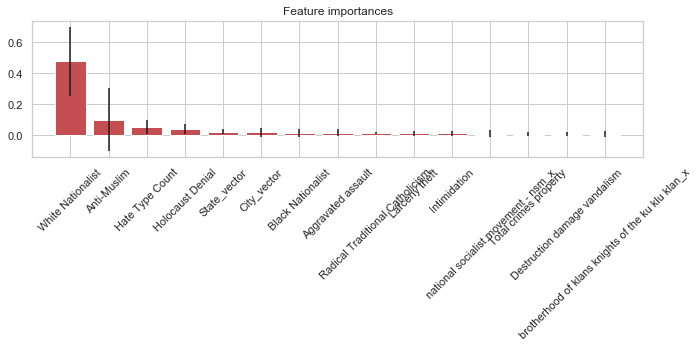

In [74]:
# Plot the feature importances of the forest

num = 15

plt.figure(figsize=[10,5])
plt.title("Feature importances")
plt.bar(range(X_train_mo.iloc[:,:num].shape[1]), importances[indices[:num]],
       color="r", yerr=std[indices[:num]], align="center")
plt.xticks(range(X_train_mo.iloc[:,:num].shape[1]), name_of_cols[indices[:num]], rotation=45)
plt.xlim([-1, X_train_mo.iloc[:,:num].shape[1]])
plt.tight_layout()
plt.show()

Using the new, reduced number of features, creating a new X.

In [75]:
X_reduced = X[name_of_cols[indices[:25]]]
Y_reduced = Y

In [76]:
X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(
    X_reduced, Y_reduced, test_size=0.6, random_state=0)

#### Random Forest on Reduced Feature Set

In [77]:
rfr = ensemble.RandomForestRegressor(n_estimators=100, warm_start=True)

rfr.fit(X_reduced_train, y_reduced_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=True)

In [78]:
test_score_rfr_red = cross_val_score(rfr, X_reduced_test, y_reduced_test, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_rfr_red),np.std(test_score_rfr_red)))

Testing score: 0.8433614947175823 +/- 0.052308130701702114


#### KNN

Using the Gridserach, the optimal number for k was 4, and the optimal weight type was uniform.

### Original set of features

In [79]:
knn = KNeighborsRegressor(n_neighbors=4, weights='uniform')

knn.fit(x_train_scaled,y_train_mo)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='uniform')

In [80]:
knn.score(x_test_scaled,y_test_mo)

0.793088378203299

In [81]:
test_score_knn = cross_val_score(knn, x_test_scaled, y_test_mo, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_knn),np.std(test_score_knn)))

Testing score: 0.7641276526823229 +/- 0.07721216021863785


### Reduced set of features

In [82]:
# scaling the reduced set

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled_red = scaler.fit_transform(X_reduced_train)
x_test_scaled_red = scaler.fit_transform(X_reduced_test)

In [83]:
knn.fit(x_train_scaled_red, y_train_mo)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='uniform')

In [84]:
knn.score(x_test_scaled_red,y_test_mo)

0.8004095009035003

In [85]:
test_score_knn_red = cross_val_score(knn, x_test_scaled_red, y_test_mo, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_knn_red),np.std(test_score_knn_red)))

Testing score: 0.8070018266111486 +/- 0.06699700755245497


I also tried using SVR, but the results were particularly weak, so I will not review that in this summary. The last model I used was the following:

#### Gradient boosting

Since Gradient boosting doesn't natively support multi outcome regression, I used sklearn's Multi Output Regressor with it.

### Original set of features

In [86]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2}

clf = ensemble.GradientBoostingRegressor(**params)

clf_mor = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params))

clf_mor.fit(X_train_mo, y_train_mo)

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
           n_jobs=1)

In [87]:
clf_mor.score(X_test_mo,y_test_mo)

0.6567889418949888

In [88]:
test_score_clf = cross_val_score(clf_mor, X_test_mo, y_test_mo, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_clf),np.std(test_score_clf)))


Testing score: 0.6353638145918392 +/- 0.08178014458155902


### Reduced set of features

In [89]:
clf_mor.fit(X_reduced_train,y_reduced_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
           n_jobs=1)

In [90]:
test_score_clf_r = cross_val_score(clf_mor, X_reduced_test, y_reduced_test, cv=10)

print('Testing score: {} +/- {}'.format(np.mean(test_score_clf_r),np.std(test_score_clf_r)))

Testing score: 0.6603899839521913 +/- 0.08272616809156123


### Partial dependence plots

I want to run the partial dependence plot on some of the features in the gradient boost, to see their importance to the model, but the sklearn implementation of partial dependence plots only works with Gradient boosting with a single outcome variable. So, I will split my outcome variable into individual outcome variables, and rerun the gradient boost on each, then get the partial dependence on the key 2 or 3 features for each outcome variable. 

In [91]:
# making a dictionary where each value is one outcome variable
single_y = {}

cols = y_reduced_train.columns.values

for col in cols:
    single_ya[col] = y_reduced_train[col]
    
# using the model as defined before

clf = ensemble.GradientBoostingRegressor(**params)

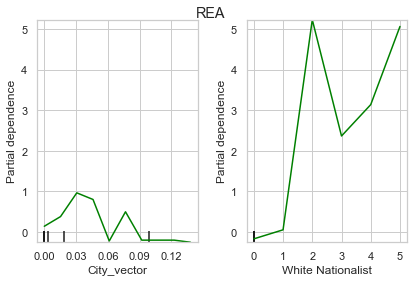

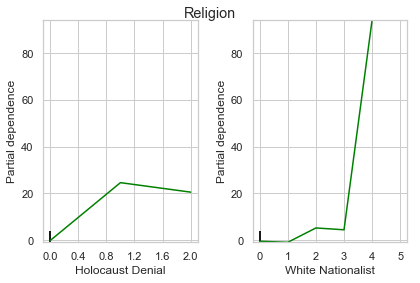

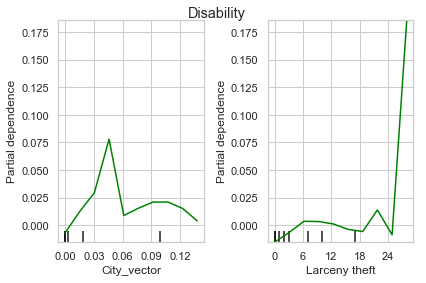

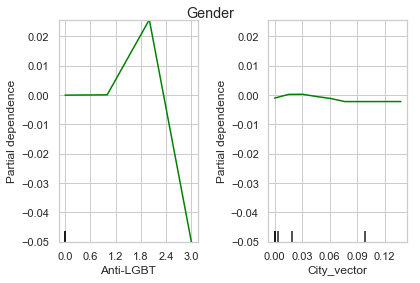

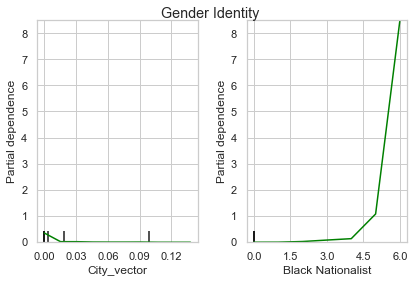

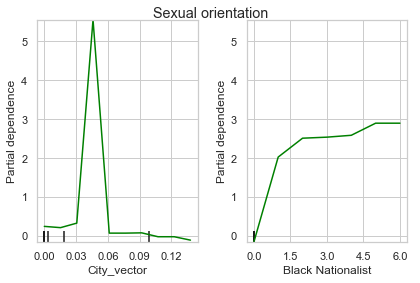

In [96]:
# make a dictionary to populate with all the info, below
d = {}

# fitting it and seeing the score to get an idea
for reqm in range(len(cols)):

    clf.fit(X_reduced_train, single_y[cols[reqm]])
    
    test_score = clf.score(X_reduced_train, single_y[cols[reqm]])

    importances = clf.feature_importances_

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Rearrange feature names so they match the sorted feature importances
    names = [X_reduced_train.columns[i] for i in indices]

    # get the 2 most important features
    important_two = []
    for i in range(2):
        num_to_add = X_reduced_train.columns.get_loc(names[i])
        important_two.append(num_to_add)

    # add the important features to the dict for later
    d.update( {cols[reqm] : (test_score, names[:2], # names of important features
            importances[important_two[0]],importances[important_two[1]] ) } )
             #the number from the feature importances


    # run the partial dependency plot

    myplots = plot_partial_dependence(clf,       
                                       features=important_two, 
                                      # column numbers of plots we want to show
                                       X=X_reduced_train,     # raw predictors data.
                                      feature_names=X_reduced_train.columns.values, 
                                      # labels on graphs
                                       grid_resolution=10) 
    plt.suptitle(cols[reqm])
    plt.tight_layout()
    plt.show()


In [93]:
for key, value in d.items():
    print(key, value)

REA (0.6243426423094253, ['City_vector', 'White Nationalist'], 0.19713194402602077, 0.07814679603492836)
Religion (0.9545887027869242, ['Holocaust Denial', 'White Nationalist'], 0.25344803252644516, 0.10489128560666643)
Disability (0.1151052627750021, ['City_vector', 'Larceny theft'], 0.16287656814497684, 0.13852065440810962)
Gender (0.7873204145369987, ['Anti-LGBT', 'City_vector'], 0.15795134475650766, 0.10811016600902928)
Gender Identity (0.8365122318235966, ['City_vector', 'Black Nationalist'], 0.18363990288566112, 0.1131619230018582)
Sexual orientation (0.8664283194956216, ['City_vector', 'Black Nationalist'], 0.18853528111893755, 0.08476703930423649)


It looks like the relationship between the top 2 most important features for each outcome variable, and the outcome variable, is generally non linear and complicated.

The information printed below the plots shows the outcome variable, the r squared value for the model fiiter, followed by the names of the top 2 most important features, and finally, the feature importance of each of the respective features.

Some of the important features that come up are not surprising - for example, "Anti LGBT" for Gender, or "Holocaust Denial" and "White Nationalist" for Religion.

Overall, though, it appears the "City_vector" is the feature with most consistent importance across the outcome variables, followed by "White Nationalist", and lastly, "Holocaust Denial", "Anti LGBT", "State_vector", "Black Nationalist", and in the Disability model, "Larceny theft". 

## Summary of all Regression Models

In [94]:
summary_models = pd.DataFrame(index= ['full - mean','full - std','reduced - mean', 'reduced - std'])

summary_models['Random forest'] = [np.mean(test_score_rfr_mo), np.std(test_score_rfr_mo),
                           np.mean(test_score_rfr_red), np.std(test_score_rfr_red)]

summary_models['KNN'] = [np.mean(test_score_knn), np.std(test_score_knn),
                           np.mean(test_score_knn_red), np.std(test_score_knn_red)]

summary_models['Gradient boosting'] = [np.mean(test_score_clf), np.std(test_score_clf),
                           np.mean(test_score_clf_r), np.std(test_score_clf_r)]


In [95]:
summary_models

,Random forest,KNN,Gradient boosting
full - mean,0.798769,0.764128,0.635364
full - std,0.072844,0.077212,0.081780
reduced - mean,0.843361,0.807002,0.660390
reduced - std,0.052308,0.066997,0.082726


## Conclusion

It appears that the impact of different hate groups on hate crimes varies at different levels - for example, when looking at the impact a single, specific hate group has on fluctuation in crimes, there is no measurable difference, according to the data I used here. 

However, the presence of hate groups in different hate types did appear to impact the types of crime and number of hate crimes in different bias categories in each city. In the models, the hate type count and the larger hate types of White Nationalist were all highly indicative of the outcome variables. And overall, in cities with hate group presence, and seemingly as the hate group presence increased, the number of hate crimes increased as well.  

Looking at the partial dependence plot, other hate groups' presence was also a predictor for certain crime types, for example, Holocaust Denial groups had a feature importance of 0.25 for hate crimes in the Religion category. As White Nationalist counts moved from 0 to 1, the increase in crime jumped from 0 to 5 in hate crimes against Race, Ethnicity and/or Ancestry.  In Religion motivated hate crimes, as White Nationalist counts increased from 3 to 4, hate crime increased from approximately 5 to about 80. 

The regression models used here were able to explain up to 84% of the variance of hate crimes, in the best case scenario, with the reduced number of features and the Random Forest model. The standard deviation was approximately 5%.

Other models used included KNN Regressor, which was able to expalin up to 82% of the variance, with a standard deviation of 6%. A gradient boosting model was used with multi output regression, and at best was able to explain 66% of the variance, with a standard deviation of 8%. 

Using the regression models, and further improving them, could help communities with known hate group presence to anticipate crimes in different categories, and construct their own preventative measures. 

### Ideas for further analysis

On a large scale, using additional tables of statistics from the FBI, including Table 4, offenses by bias category, could help categorize and compare hate types by their types of crimes.

Also, it is possible that hate crimes that are reported are unclassified as such. In order to include all hate crimes, it could be useful to have access to more crime data and, using features in that data, determine which of the crimes are hate crimes. Then, the analysis here could be rerun and perhaps different features would stand out as identifiable.

Finally, using natural language processing techniques could yield some interesting results. In this project I simply extracted keywords and used vectors of hate groups in each city / state to represent city / state similiarity of hate group profiles. 

However, analyzing texts produced and published by hate groups, or even their texts shared on their social media presences, could reveal some keywords in their rhetoric. Then, different paths could be taken - for example, articles could be examined for bias, using a count of their keywords as a feature, and perhaps the hate group or hate type it was from could be determined.
